# Standard Filtering

This notebook is meant as a tutorial to start using our library. While it doesn't go into any mathematical details, it is meant to give an overview of the high-level code at play.

## Imports

First thing first: let's import what we'll be needing.

In [1]:
import sys
sys.path.append("../..")

In [2]:
# tensorflow imports
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [3]:
# filterflow model imports
from filterflow import SMC, State
from filterflow.observation import LinearObservationModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.transition import RandomWalkModel

In [5]:
# filterflow resampling imports
from filterflow.resampling import NeffCriterion, MultinomialResampler, RegularisedTransform

### Create some fake data
If you have real data you can always feed it instead

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Some data parameters
np_random_state = np.random.RandomState(42)
T = 150
noise = 0.5

In [7]:
# Here we simply use a noisy sine function
linspace = np.linspace(0., 5., T)
sine = np.sin(linspace)
noisy_sine = sine + np_random_state.normal(0., noise, T)

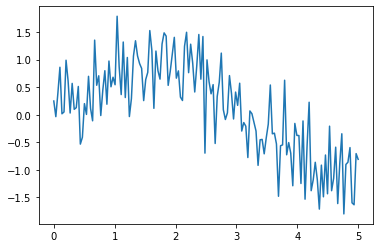

In [8]:
_ = plt.plot(linspace, noisy_sine)

### The model

Let's have a look at our objects.

In [9]:
LinearObservationModel?

Init signature:
LinearObservationModel(
    observation_matrix: tensorflow.python.framework.ops.Tensor,
    error_rv: tensorflow_probability.python.distributions.distribution.Distribution,
    name='LinearObservationModel',
)
Docstring:      Base class for filterflow Modules - __call__ is ignored
File:           
Type:           ABCMeta
Subclasses:     LinearObservationSampler


So LinearObservationModel takes an observation matrix in the form of a tensor and an error random variable in the form of a tfp distribution.

As a first step, let's simply encode the following SSM for a 1 dimensional filter:
$$X_{t+1}|X_t=x_t \sim \mathcal{N}(x_t, \sigma_X^2), \quad Y_t|X_t=x_t \sim \mathcal{N}(x_t, \sigma_Y^2)$$

In [10]:
sigma_x = 0.5
sigma_y = 1.

observation_matrix = tf.eye(1)
transition_matrix = tf.eye(1)

transition_noise = tfd.MultivariateNormalDiag(tf.constant([sigma_x]))
observation_error = tfd.MultivariateNormalDiag(0., tf.constant([sigma_y]))

In [11]:
transition_model = RandomWalkModel(transition_matrix, transition_noise)
observation_model = LinearObservationModel(observation_matrix, observation_error)

In [12]:
# Now we need a proposal distribution. In the most simple case, we can use the Bootstrap proposal.
proposal_model = BootstrapProposalModel(transition_model)

In [13]:
# Let's resample when the ESS drops below 50%
resampling_criterion = NeffCriterion(0.5, is_relative=True)

# And use multinomial resampling
resampling_method = MultinomialResampler()

We can now build our Particle Filter

In [14]:
smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, resampling_method)

Now this filter doesn't encode the number of particles or the state dimension by itself. This is delegated to the State object:

In [15]:
batch_size = 5
n_particles = 50
dimension = 1
initial_state = State(np_random_state.normal(0., 1., [batch_size, n_particles, dimension]).astype(np.float32))

print(initial_state.batch_size)
print(initial_state.n_particles)
print(initial_state.dimension)

5
50
1


What is this batch size though and where is it coming from???
This is a technical aid to be able to run filters by batch while retaining the benefit of calculations vectorization.

Additionally, for efficiency reasons, the library is coded against tf.data.Dataset objects, this allows for faster looping through tensors:

In [16]:
observations_dataset = tf.data.Dataset.from_tensor_slices(noisy_sine.astype(np.float32))

That's it! We are ready to go. SMC is a callable function, you can therefore directly call it on the data you need:

In [17]:
%%time
state_series = smc(initial_state, observations_dataset, T, return_final=False, seed=555)

Wall time: 4.72 s


Well, that was awefully slow wasn't it?
Let's do it again.

In [18]:
%%time
state_series = smc(initial_state, observations_dataset, T, return_final=False, seed=555)

Wall time: 62 ms


That's much better. This difference is because tensorflow does some graph optimization at the first run of the filter, and it is reused afterwards. This is particularily useful if the values change but not the shapes, e.g. during an optimization.

So what's in state_series? Is is an attr class, so we can use this to inspect the object:

In [19]:
import attr
print(type(state_series))
for field in attr.fields(type(state_series)):
    print(field.name)


<class 'filterflow.base.FloatStateSeries'>
batch_size
n_particles
dimension
particles
log_weights
weights
log_likelihoods


Let's have a look at the particles and weights:

In [20]:
print(type(state_series.particles))
print(type(state_series.weights))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [21]:
print(state_series.particles.shape)
print(state_series.weights.shape)

(150, 5, 50, 1)
(150, 5, 50)


It is a time series of batched particle filter states. Not really handy by default! Thankfully, there are helpers: let's look at the mean and standard deviation:

In [22]:
from filterflow import mean, std
mean_particles = mean(state_series, keepdims=True)
std_particles = std(state_series, mean_particles) # the mean argument is optional


And let's get back to the numpy space:

In [23]:
mean_particles = mean_particles.numpy().squeeze()
std_particles = std_particles.numpy().squeeze()

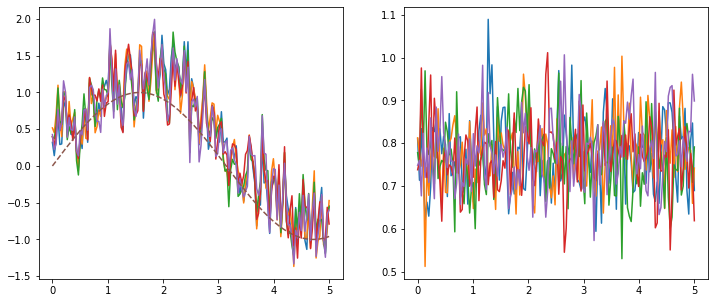

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].plot(linspace, mean_particles)
axes[0].plot(linspace, sine, linestyle='--')

_ = axes[1].plot(linspace, std_particles)

Alternatively you can request the last state only. This is useful when interested in the loglikelihood:

In [25]:
final_state = smc(initial_state, observations_dataset, T, return_final=True, seed=12345)

In [26]:
final_state.log_likelihoods

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-238.98355, -239.25224, -242.9767 , -240.9075 , -238.25276],
      dtype=float32)>

These are the batched loklikelihoods of the run.

Our library also allows you to compute the "gradient" (using a biased estimate in the case of the Multinomial Resampler) of the filter with respect to its parameters really easily:

In [27]:
with tf.GradientTape() as tape:
    tape.watch(observation_matrix)
    final_state = smc(initial_state, observations_dataset, T, return_final=True, seed=12345)

tape.gradient(final_state.log_likelihoods, observation_matrix)
# Note that the gradient is taken on the sum of log_likelihoods.

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-434.93314]], dtype=float32)>

This allows to do gradient descent on whichever model you are interested in.

See gradient descent tutorial.